# Main datasets API

This notebook is a quick dive in the main user API for loading datasets in `datasets`

In [ ]:
# pip install textstat
#!pip install rake-nltk
!pip install -U spacy

In [ ]:
import matplotlib.pyplot as plt
import textstat
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import nltk
from rake_nltk import Rake
#r = Rake()
import spacy
nlp = spacy.load('en_core_web_lg')

In [ ]:
import pandas as pd

# make sure this points to the right place on your system:
data_file = 'Sentences_50Agree.txt'

df = pd.read_csv(data_file, sep='.@', header=0, names=['sentence', 'label'], encoding="windows_1258")

# change the words in the label column to numbers
df.loc[df["label"]=="negative", "label"] = 0
df.loc[df["label"]=="neutral", "label"] = 1
df.loc[df["label"]=="positive", "label"] = 2

# convert from a dataframe object to a dictionary of arrays
dataset = {
    "sentence": df["sentence"].to_numpy(),
    "label": df["label"].to_numpy()
}

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [ ]:


df1 = pd.read_csv(data_file, sep='.@', header=0, names=['sentence', 'label'], encoding="windows_1258")


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



EDA

In [ ]:
unique_sentiments = df.label.unique()
unique_sentiments

array([1, 0, 2], dtype=object)

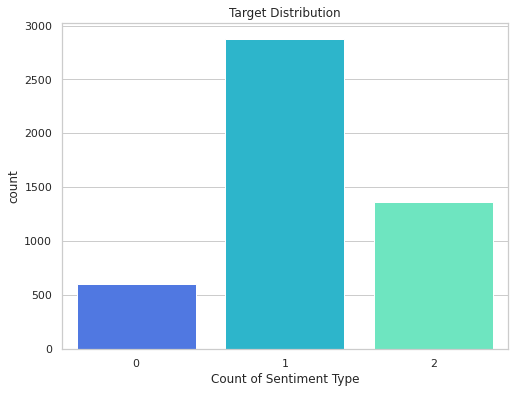

<Figure size 432x288 with 0 Axes>

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_palette('rainbow')
plt.figure(figsize=(8,6))
sns.countplot(x=df.label)
plt.xlabel('Count of Sentiment Type')
plt.title('Target Distribution')
plt.show()
plt.savefig('Target Distribution')

Imbalanced dataset, 'neutral' class dominates the other 2 classes.

Calculating length of each sentence could let us know if sentence length varies substantially by class.

In [ ]:
df['Sentence Length'] = df['sentence'].apply(lambda x : textstat.lexicon_count(x, removepunct=True))

Plotting Sentence Lengths for each class

In [ ]:
df_positive = df.loc[df['label'] == 2]
df_negative = df.loc[df['label'] == -1]
df_neutral = df.loc[df['label'] == 1]


fig = make_subplots(rows=1, cols=3)

fig.append_trace(
    go.Box(name='Positive', y=df_positive['Sentence Length']),
    row=1, col=1
)

fig.append_trace(
    go.Box(name='Negative', y=df_negative['Sentence Length']),
    row=1, col=2
)

fig.append_trace(
    go.Box(name='Neutral', y=df_neutral['Sentence Length']),
    row=1, col=3
)



fig.update_layout(height=500, width=700, title_text="Distribution of Sentence Length across classes")
fig.show()

More or less the same across classes, so sentence length is invariant to sentiment type

Extracting the top 100 phrases for each class

In [ ]:
negative_corpus = df_negative['sentence'].tolist()
negative_corpus = " ".join(negative_corpus)
r.extract_keywords_from_text(negative_corpus)
top_phrases_neg = r.get_ranked_phrases()[0:100]


positive_corpus = df_positive['sentence'].tolist()
positive_corpus = " ".join(positive_corpus)
r.extract_keywords_from_text(positive_corpus)
top_phrases_pos = r.get_ranked_phrases()[0:100]


neutral_corpus = df_neutral['sentence'].tolist()
neutral_corpus = " ".join(neutral_corpus)
r.extract_keywords_from_text(neutral_corpus)
top_phrases_neutral = r.get_ranked_phrases()[0:100]

pd.DataFrame({'Top Negative Phrases':top_phrases_neg,'Top Positive Phrases':top_phrases_pos,'Top Neutral Phrases':top_phrases_neutral})

In a financial news snippet; Companies, Top executives and Countries are the frequently referred-to entitites. spaCy's built in NER model can be used to determine their counts

In [ ]:
def ner_counter(doc):
    gpe_count = 0
    org_count = 0
    person_count = 0
    money_count=0
    for tok in doc.ents:
        if tok.label_ == "GPE":
            gpe_count = gpe_count + 1
        elif tok.label_ == "ORG":
            org_count=org_count+1
        elif tok.label_ == "PERSON":
            person_count=person_count+1
        elif tok.label_ == "MONEY":
            money_count=money_count+1
    return (gpe_count,org_count,person_count,money_count)

sentences = df['sentence'].tolist()
sentences = " ".join(sentences)
sentences = nlp(sentences)
entity_counts = list(ner_counter(sentences))
entity_df = {'Entity Type':['GPE', 'ORG', 'PERSON', 'MONEY'],
        'Count':entity_counts}
fig = px.bar(entity_df,x='Entity Type',y='Count',color='Entity Type')
fig.update_layout(height=500,width=500)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.utils import resample
from sklearn.metrics import classification_report

Understanding algorithm 


In [ ]:
from sklearn.model_selection import train_test_split

# Split test data from training data
train_sentences, test_sentences, train_labels, test_labels = train_test_split(
    dataset['sentence'], 
    dataset['label'], 
    test_size=0.2, 
    stratify=dataset['label']  # make sure the same proportion of labels is in the test set and training set
)


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(df1['sentence'], df1['label'])

In [ ]:
SD_clf = Pipeline([('cv', CountVectorizer(ngram_range=(1,2))),('clf',  SGDClassifier(class_weight = 'balanced',max_iter=10000,n_iter_no_change=10))])


In [ ]:
SD_clf.fit(X_train,y_train)

Pipeline(steps=[('cv', CountVectorizer(ngram_range=(1, 2))),
                ('clf',
                 SGDClassifier(class_weight='balanced', max_iter=10000,
                               n_iter_no_change=10))])

In [ ]:
y_pred = SD_clf.predict(X_test)
pd.DataFrame(classification_report(y_pred,y_test,output_dict=True)).T

,precision,recall,f1-score,support
negative,0.513158,0.750000,0.609375,104.0000
neutral,0.860563,0.783333,0.820134,780.0000
positive,0.640000,0.682927,0.660767,328.0000
accuracy,0.753300,0.753300,0.753300,0.7533
macro avg,0.671240,0.738753,0.696759,1212.0000
weighted avg,0.771063,0.753300,0.758920,1212.0000


The extremely poor precision and recall scores for the 'negative' class confirms that class-imabalance is indeed the issue

Oversampling the negative and positive classes could help.

In [ ]:
df_neutral = df1[(df1['label']=='neutral')] 
df_negative = df1[(df1['label']=='negative')]
df_positive = df1[(df1['label']=='positive')]


# upsample minority classes
df_negative_upsampled = resample(df_negative, 
                                 replace=True,    
                                 n_samples= 2000, 
                                 random_state=42)  

df_positive_upsampled = resample(df_positive, 
                                 replace=True,    
                                 n_samples= 2000, 
                                 random_state=42)  


# Concatenate the upsampled dataframes with the neutral dataframe
df_upsampled = pd.concat([df_negative_upsampled,df_neutral,df_positive_upsampled])

Fitting the model again where the negative and positive class is oversampled by 2000 samples each

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(df_upsampled['sentence'], df_upsampled['label'])
SD_clf_upsampled = Pipeline([('cv', CountVectorizer(ngram_range=(1,2))),('clf',  SGDClassifier(class_weight = 'balanced',max_iter=20000,n_iter_no_change=10))])

SD_clf_upsampled.fit(X_train,y_train)

Pipeline(steps=[('cv', CountVectorizer(ngram_range=(1, 2))),
                ('clf',
                 SGDClassifier(class_weight='balanced', max_iter=20000,
                               n_iter_no_change=10))])

In [ ]:
SD_clf_upsampled.score(X_test, y_test)

0.9122093023255814

91% now!, that's a pretty impressive step-up from the model trained with the unsampled dataset.

In [ ]:
y_pred = SD_clf_upsampled.predict(X_test)
pd.DataFrame(classification_report(y_pred,y_test,output_dict=True)).T

,precision,recall,f1-score,support
negative,0.979879,0.960552,0.970120,507.000000
neutral,0.899045,0.903978,0.901505,729.000000
positive,0.863265,0.873967,0.868583,484.000000
accuracy,0.912209,0.912209,0.912209,0.912209
macro avg,0.914063,0.912832,0.913402,1720.000000
weighted avg,0.912804,0.912209,0.912466,1720.000000


Precision, Recall and F1 have increased for all the classes

Finally, Eli5 can assist with interpreting the model

In [ ]:
pip install eli5

     |████████████████████████████████| 106 kB 5.2 MB/s 


In [ ]:
import eli5

In [ ]:
eli5.explain_weights(SD_clf_upsampled)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



Explanation(estimator="Pipeline(steps=[('cv', CountVectorizer(ngram_range=(1, 2))),\n                ('clf',\n                 SGDClassifier(class_weight='balanced', max_iter=20000,\n                               n_iter_no_change=10))])", description="\nFeatures with largest coefficients per class.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target='negative', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='down', weight=3.103483240052442, std=None, value=None), FeatureWeight(feature='decreased', weight=2.870736901671771, std=None, value=None), FeatureWeight(feature='fell', weight=2.060500288882481, std=None, value=None), FeatureWeight(feature='dropped', weight=1.6473867167242355, std=None, value=None), FeatureWeight(feature='staff', weight=1.6204732255785772, std=None, value=None), FeatureWeight(feature='jobs', weight=1.5513796506041695, std=None, value=None), FeatureWeight(feature='off', weight=1.524466159458512, std=None, value=None), FeatureWeight(feature='lower', weight=1.4837339533179714, std=None, value=None), FeatureWeight(feature='down from', weight=1.4277351544943384, std=None, value=None), FeatureWeight(feature='decreased to', weight=1.3179093733793867, std=None, value=None), FeatureWeight(feature='cut', weight=1.290995882233732, std=None, value=None), FeatureWeight(feature='declined', weight=1.2771771672388528, std=None, value=None), FeatureWeight(feature='to eur', weight=1.2553312480019447, std=None, value=None)], neg=[FeatureWeight(feature='<BIAS>', weight=-3.097617696423409, std=None, value=None), FeatureWeight(feature='rose', weight=-1.6714044524934595, std=None, value=None), FeatureWeight(feature='rose to', weight=-1.6321201240411378, std=None, value=None), FeatureWeight(feature='increased', weight=-1.5201225263938598, std=None, value=None), FeatureWeight(feature='increase', weight=-1.4401059918010053, std=None, value=None), FeatureWeight(feature='up from', weight=-1.4401059918010017, std=None, value=None), FeatureWeight(feature='up', weight=-1.4241154602737947, std=None, value=None)], pos_remaining=6820, neg_remaining=10166), proba=None, score=None, weighted_spans=None, heatmap=None), TargetExplanation(target='neutral', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=1.157211158879691, std=None, value=None), FeatureWeight(feature='approximately', weight=0.906138276261904, std=None, value=None)], neg=[FeatureWeight(feature='leading', weight=-1.3029488508662317, std=None, value=None), FeatureWeight(feature='negative', weight=-1.2538346442871116, std=None, value=None), FeatureWeight(feature='positive', weight=-1.2200093615756535, std=None, value=None), FeatureWeight(feature='loss', weight=-1.2167619265995135, std=None, value=None), FeatureWeight(feature='down', weight=-1.1351214112993895, std=None, value=None), FeatureWeight(feature='jobs', weight=-1.0866566917154954, std=None, value=None), FeatureWeight(feature='signed', weight=-1.0642234109003337, std=None, value=None), FeatureWeight(feature='growing international', weight=-1.0030677154296903, std=None, value=None), FeatureWeight(feature='sales', weight=-0.9497578228613984, std=None, value=None), FeatureWeight(feature='grew', weight=-0.9194787391438833, std=None, value=None), FeatureWeight(feature='off', weight=-0.9181797651534265, std=None, value=None), FeatureWeight(feature='increased', weight=-0.9162313041677456, std=None, value=None), FeatureWeight(feature='performance', weight=-0.9015918672953093, std=None, value=None), FeatureWe

Negative classes are defined by verbs such as 'down', 'decreased', 'fall', 'lower' etc, to indicate some quantity going down.

The converse is true for positive class, verbs such as 'increased', 'up', grew', 'rise' indicate a positive sentiment.

Interestingly, Verbs not adjectives are the most important features here, usually models rely on adjectives and adverbs for sentiment classification.

The distinction between 'neutral' and 'positive' sentence is very subjective and varies across people. Any ML model is sure to have a hard time distinguishing between them.

Closing Remarks
Finance is one of the domains where NLP techniques are being adopted at an accelerated rate, the ability to classify financial news into sentiment-defined buckets saves a lot of time & effort for workers in financial analysis based roles.

Even with a dataset of just 5.8k records, a model with decent accuracy was achieved, suggesting that more data coupled with high quality labels and the right amount of variance can make sentiment analysis the de-facto paradigm to sort financial news.

In [ ]:
dataset.shape

(4846, 2)

In [ ]:
# label 0 = negative, 1 = neutral, 2 = positive
print(f'How many instances in the train dataset? \n\n{len(train_sentences)}')
print('')
print(f'What does one instance look like? \n\n{train_sentences[234]}')

How many instances in the train dataset? 

3876

What does one instance look like? 

Production will expand to other of Elcoteq 's locations including Mexico and Hungary during 2010 .


In [ ]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_sentences, train_labels, test_size=0.25, stratify=train_labels)


In [ ]:
print(f'How many instances in the validation dataset? \n\n{len(val_sentences)}\n')
print(f'How many instances in the test dataset? \n\n{len(test_sentences)}')

How many instances in the validation dataset? 

969

How many instances in the test dataset? 

970
